In [1]:
import glob
from os import getcwd
import os
import pickle 
import pandas as pd
import numpy as np
import datetime
import random
import matplotlib.pyplot as plt

In [2]:
import random
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer


In [3]:
def summaryGridresult(grid_result, tablename, printrow=6):
   print(tablename)
   print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
   res_tab = pd.DataFrame(grid_result.cv_results_).sort_values(by=['mean_test_score'], ascending=False)
   res_tab = res_tab[['params','mean_train_score','std_test_score','mean_test_score','std_test_score']]
   return res_tab[:printrow]

In [4]:
# precision
def get_pre(true, pred,threshold = 0.1): # the difference is not bigger than 3
    TP = 0
    for i in range(len(true)):
        if (true[i]) == 0:
            if abs(true[i]-pred[i]) <= 3:
                TP +=1 
        else:
            if abs(true[i]-pred[i])/(true[i])<= threshold:
                TP +=1
    return TP/len(true)

def getmetrics(true, pred):
    r2 = r2_score(true, pred)
    mae = mean_absolute_error(true, pred)
    mse = mean_squared_error(true, pred)
    return mae, r2, mse

In [5]:
# Plot prediction
%matplotlib inline
def plotprediction(true, pred, modelname):
    pred_table = pd.DataFrame({'preds': pred}, index = true.index)
    prediction_table = true.join(pred_table)
    prediction_table = prediction_table.rename(columns = {'sales': 'true'})
    
    fig, ax = plt.subplots(figsize=(20,5))
    ax.plot(prediction_table['true'], label='Truth')
    ax.plot(prediction_table['preds'], label='Prediction')
    ax.set_title('Comparing prediction from {}'.format(modelname), fontsize=20)
    ax.set_xlabel('Time', fontsize=16)
    ax.set_ylabel('Sales', fontsize=16)
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(8)
    leg = ax.legend(fontsize = 18)

In [6]:
# set seed
seed = 12345
#Storing model outcome:

all_outcome = {}

#### import data

In [7]:
# get working directory
path = os.path.dirname(getcwd())
os.chdir(path)
with open("data/full_features/f-regression/traindt.pkl", 'rb') as f:
   xtrain_df, ytrain_df =  pickle.load(file = f)
with open("data/full_features/f-regression/testdt.pkl", 'rb') as f:
   xtest_df, ytest_df =  pickle.load(file = f)
with open("data/full_features/f-regression/traindt-tf.pkl", 'rb') as f:
   xtrain, ytrain =  pickle.load(file = f)
with open("data/full_features/f-regression/testdt-tf.pkl", 'rb') as f:
   xtest, ytest =  pickle.load(file = f)

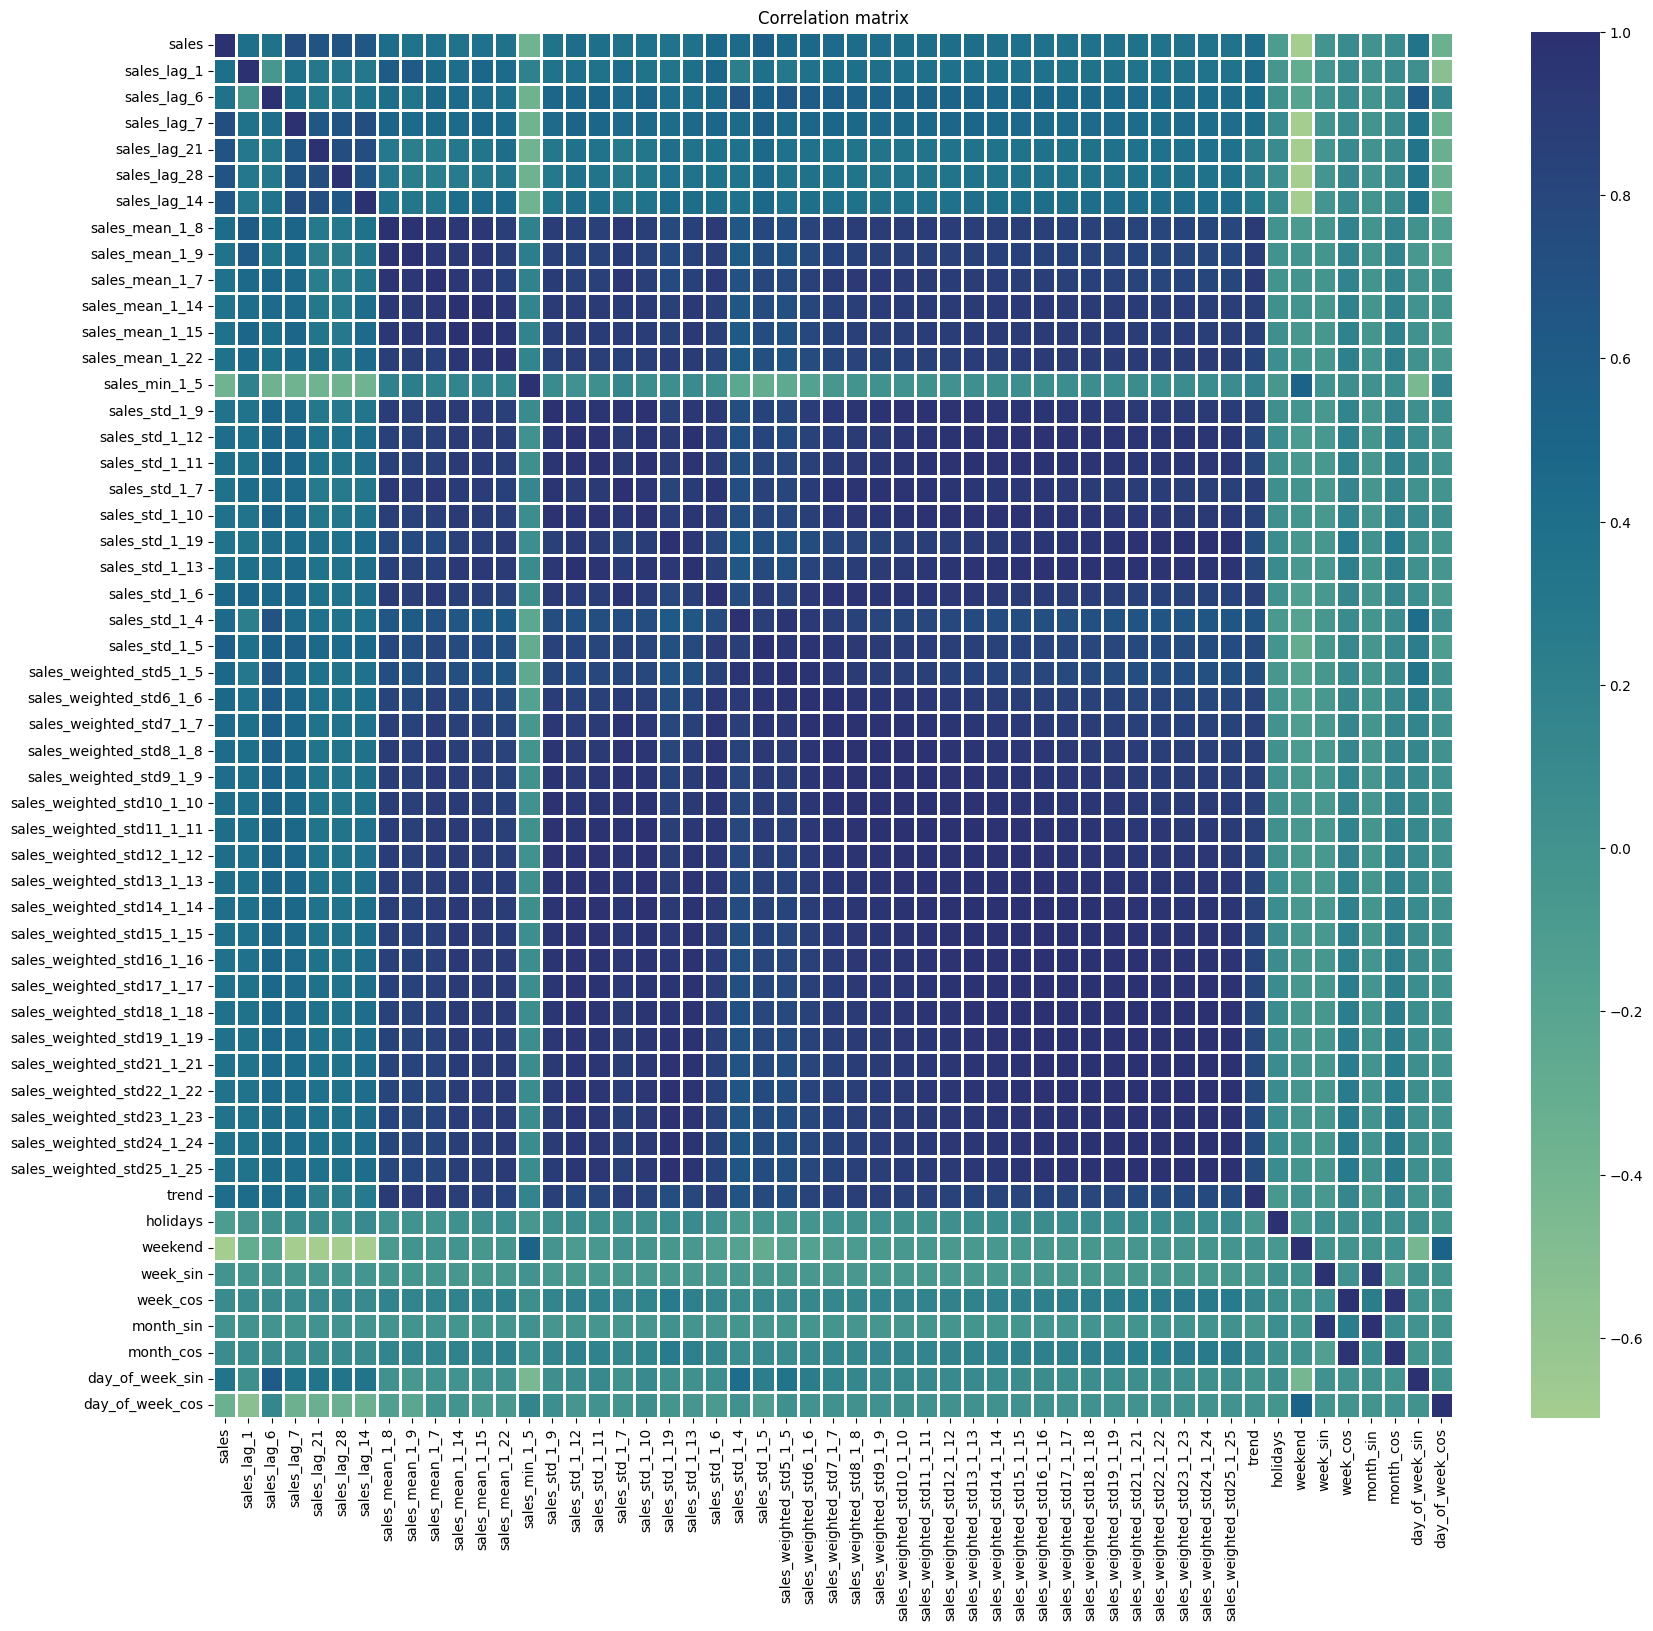

In [8]:
import seaborn as sns
test_corr_df = ytrain_df.join(xtrain_df, how = 'right')
corr_matrix = test_corr_df.reset_index().drop('Date', axis = 1).corr()
plt.figure(figsize=(20,18))
sns.heatmap(corr_matrix,annot=False,linewidth=.9,cmap='crest')
plt.title("Correlation matrix")
plt.show()

### Baseline Linear model: OLS

In [9]:
random.seed(seed)
ols = LinearRegression()
ols_grid_pams = {'fit_intercept': [True, False]}
ols_grid_mod = GridSearchCV(ols, ols_grid_pams
                       , cv = 4, scoring = 'r2', 
                       return_train_score = True, 
                       n_jobs=-1)
grid_ols_res = ols_grid_mod.fit(xtrain, np.ravel(ytrain, 'C'))

In [10]:
summaryGridresult(grid_ols_res, 'Best results for simple linear model')

Best results for simple linear model
Best: 0.621509 using {'fit_intercept': True}


,params,mean_train_score,std_test_score,mean_test_score,std_test_score
0,{'fit_intercept': True},0.771337,0.062842,0.621509,0.062842
1,{'fit_intercept': False},0.059484,2.319323,-4.102846,2.319323


In [11]:
random.seed(seed)
ols_preds = ols_grid_mod.predict(xtest)

OLStest_out = {'mae': getmetrics(ytest, ols_preds)[0], 
               'r2':getmetrics(ytest, ols_preds)[1], 
               'mse': getmetrics(ytest, ols_preds)[2],
               'precision 10%': get_pre(ytest, ols_preds), 
               'precision 20%': get_pre(ytest, ols_preds, 0.2),
               'precision 30%': get_pre(ytest, ols_preds, 0.3)}

all_outcome['OLS'] = OLStest_out

OLStest_out

{'mae': 8.840420662393196,
 'r2': 0.7444164976790528,
 'mse': 140.0711612356709,
 'precision 10%': 0.34615384615384615,
 'precision 20%': 0.5,
 'precision 30%': 0.6153846153846154}

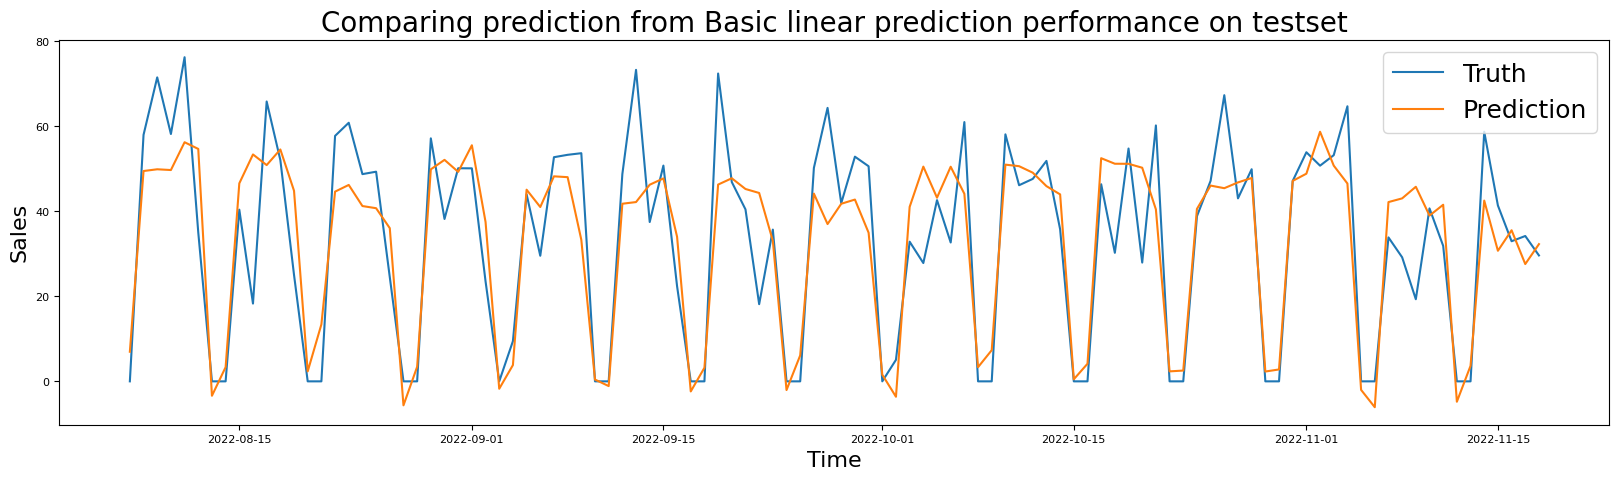

In [12]:
plotprediction(ytest_df, ols_preds.flatten(), 
               'Basic linear prediction performance on testset')

### Lasso Linear

In [13]:
# Grid search
lasso = Lasso(random_state=0, max_iter=50000)
ls_grid_pams = {'alpha':[0.01, 0.1, 1, 10, 100],
                 'selection':['cyclic','random']}

ls_grid_mod = GridSearchCV(lasso, ls_grid_pams
                       , cv = 4, scoring = 'r2',
                       return_train_score=True, 
                       n_jobs=-1)
ls_grid_res=ls_grid_mod.fit(xtrain, ytrain)

In [14]:
summaryGridresult(ls_grid_res, 'Best result for Lasso model')

Best result for Lasso model
Best: 0.660048 using {'alpha': 0.1, 'selection': 'random'}


,params,mean_train_score,std_test_score,mean_test_score,std_test_score
3,"{'alpha': 0.1, 'selection': 'random'}",0.744260,0.048211,0.660048,0.048211
2,"{'alpha': 0.1, 'selection': 'cyclic'}",0.744273,0.048281,0.660020,0.048281
1,"{'alpha': 0.01, 'selection': 'random'}",0.760011,0.044873,0.648765,0.044873
0,"{'alpha': 0.01, 'selection': 'cyclic'}",0.760039,0.044776,0.648651,0.044776
5,"{'alpha': 1, 'selection': 'random'}",0.714029,0.053961,0.639529,0.053961
4,"{'alpha': 1, 'selection': 'cyclic'}",0.714012,0.053994,0.639464,0.053994


In [15]:
random.seed(seed)
ls_preds = ls_grid_mod.predict(xtest)

LSTest_out = {'mae': getmetrics(ytest, ls_preds)[0], 
               'r2':getmetrics(ytest, ls_preds)[1], 
               'mse': getmetrics(ytest, ls_preds)[2],
               'precision 10%': get_pre(ytest, ls_preds), 
               'precision 20%': get_pre(ytest, ls_preds, 0.2),
               'precision 30%': get_pre(ytest, ls_preds, 0.3)}
all_outcome['lasso'] = LSTest_out
LSTest_out


{'mae': 8.878779880772518,
 'r2': 0.7390102704046155,
 'mse': 143.0340149619786,
 'precision 10%': 0.3269230769230769,
 'precision 20%': 0.5096153846153846,
 'precision 30%': 0.6057692307692307}

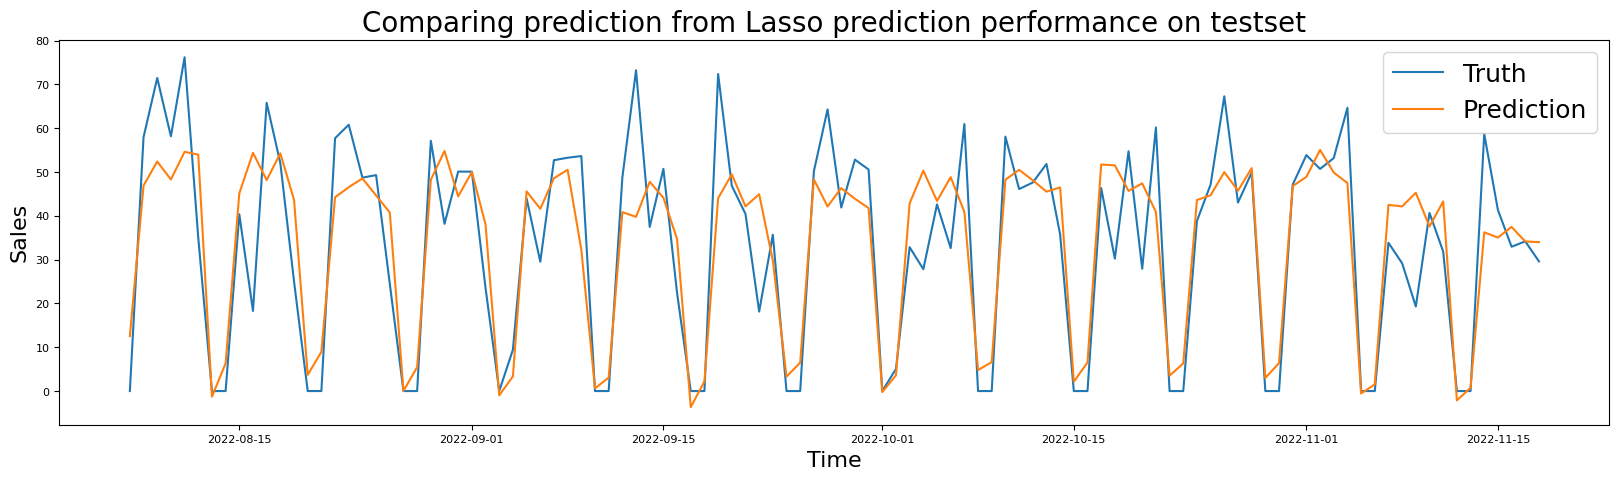

In [16]:
plotprediction(ytest_df, ls_preds, 
               'Lasso prediction performance on testset')

# Ridge Linear

In [17]:
# Grid search
random.seed(seed)
ridge = Ridge(random_state=0, max_iter=50000)
rid_grid_pams = {'alpha':[0.01, 0.1, 1, 10, 100],
                 'solver':['svd', 'cholesky', 'sparse_cg', 'lsqr', 'sag']}
rid_grid_mod = GridSearchCV(ridge, rid_grid_pams,
                           cv = 4, scoring = 'r2',
                           return_train_score=True)
rid_grid_res = rid_grid_mod.fit(xtrain, ytrain)

In [18]:
summaryGridresult(rid_grid_res, 'Best result for Ridge Linear model')

Best result for Ridge Linear model
Best: 0.666070 using {'alpha': 10, 'solver': 'lsqr'}


,params,mean_train_score,std_test_score,mean_test_score,std_test_score
18,"{'alpha': 10, 'solver': 'lsqr'}",0.750070,0.037158,0.666070,0.037158
19,"{'alpha': 10, 'solver': 'sag'}",0.750368,0.039123,0.664516,0.039123
17,"{'alpha': 10, 'solver': 'sparse_cg'}",0.750353,0.038882,0.664437,0.038882
16,"{'alpha': 10, 'solver': 'cholesky'}",0.750651,0.039100,0.664404,0.039100
15,"{'alpha': 10, 'solver': 'svd'}",0.750651,0.039100,0.664404,0.039100
23,"{'alpha': 100, 'solver': 'lsqr'}",0.725506,0.024294,0.662984,0.024294


In [19]:
random.seed(seed)
rid_preds = rid_grid_mod.predict(xtest)

RidTest_out = {'mae': getmetrics(ytest, rid_preds)[0], 
               'r2':getmetrics(ytest, rid_preds)[1], 
               'mse': getmetrics(ytest, rid_preds)[2],
               'precision 10%': get_pre(ytest, rid_preds), 
               'precision 20%': get_pre(ytest, rid_preds, 0.2),
               'precision 30%': get_pre(ytest, rid_preds, 0.3)}
all_outcome['Ridge']=RidTest_out
RidTest_out


{'mae': 8.63224431121223,
 'r2': 0.7460438614618532,
 'mse': 139.1792932835545,
 'precision 10%': 0.3557692307692308,
 'precision 20%': 0.5192307692307693,
 'precision 30%': 0.6153846153846154}

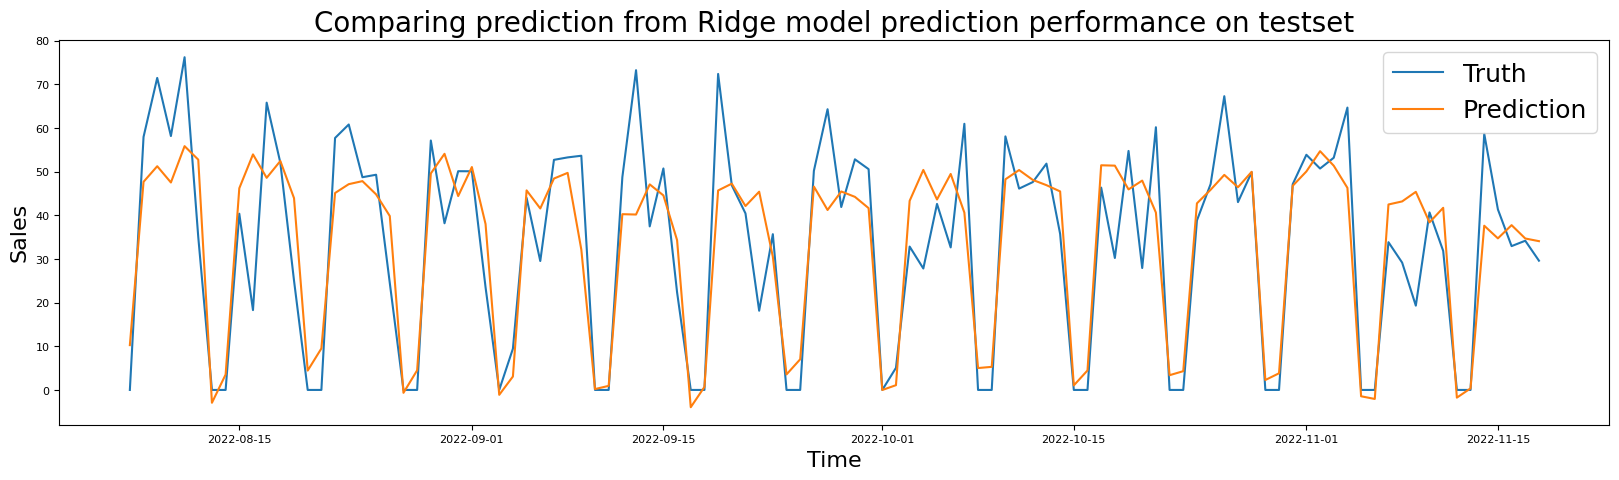

In [20]:
plotprediction(ytest_df, rid_preds.flatten(), 
               'Ridge model prediction performance on testset')

# KNN Knearest neighbors

In [21]:
# Grid search
random.seed(seed)
knn = KNeighborsRegressor()
knn_grid_pams = {'n_neighbors' : [5,10,15,20],
               'weights':['uniform', 'distance']}
knn_grid_mod = GridSearchCV(knn, knn_grid_pams
                       , cv = 4, scoring = 'r2',
                       return_train_score=True)

knn_grid_res = knn_grid_mod.fit(xtrain, ytrain)

In [22]:
summaryGridresult(knn_grid_res, 'Best results for KNN model')

Best results for KNN model
Best: 0.553206 using {'n_neighbors': 20, 'weights': 'distance'}


,params,mean_train_score,std_test_score,mean_test_score,std_test_score
7,"{'n_neighbors': 20, 'weights': 'distance'}",1.000000,0.053469,0.553206,0.053469
6,"{'n_neighbors': 20, 'weights': 'uniform'}",0.706922,0.054344,0.551668,0.054344
5,"{'n_neighbors': 15, 'weights': 'distance'}",1.000000,0.054497,0.548904,0.054497
4,"{'n_neighbors': 15, 'weights': 'uniform'}",0.727478,0.054764,0.548840,0.054764
2,"{'n_neighbors': 10, 'weights': 'uniform'}",0.756794,0.058878,0.541159,0.058878
3,"{'n_neighbors': 10, 'weights': 'distance'}",1.000000,0.059682,0.538970,0.059682


In [23]:
knn_preds = knn_grid_mod.predict(xtest)

knn_out = {'mae': getmetrics(ytest, knn_preds)[0], 
               'r2':getmetrics(ytest, knn_preds)[1], 
               'mse': getmetrics(ytest, knn_preds)[2],
               'precision 10%': get_pre(ytest, knn_preds), 
               'precision 20%': get_pre(ytest, knn_preds, 0.2),
               'precision 30%': get_pre(ytest, knn_preds, 0.3)}
all_outcome['KNN15']=knn_out

knn_out

{'mae': 8.369685373651338,
 'r2': 0.7383267960804395,
 'mse': 143.4085893824429,
 'precision 10%': 0.46153846153846156,
 'precision 20%': 0.6153846153846154,
 'precision 30%': 0.7211538461538461}

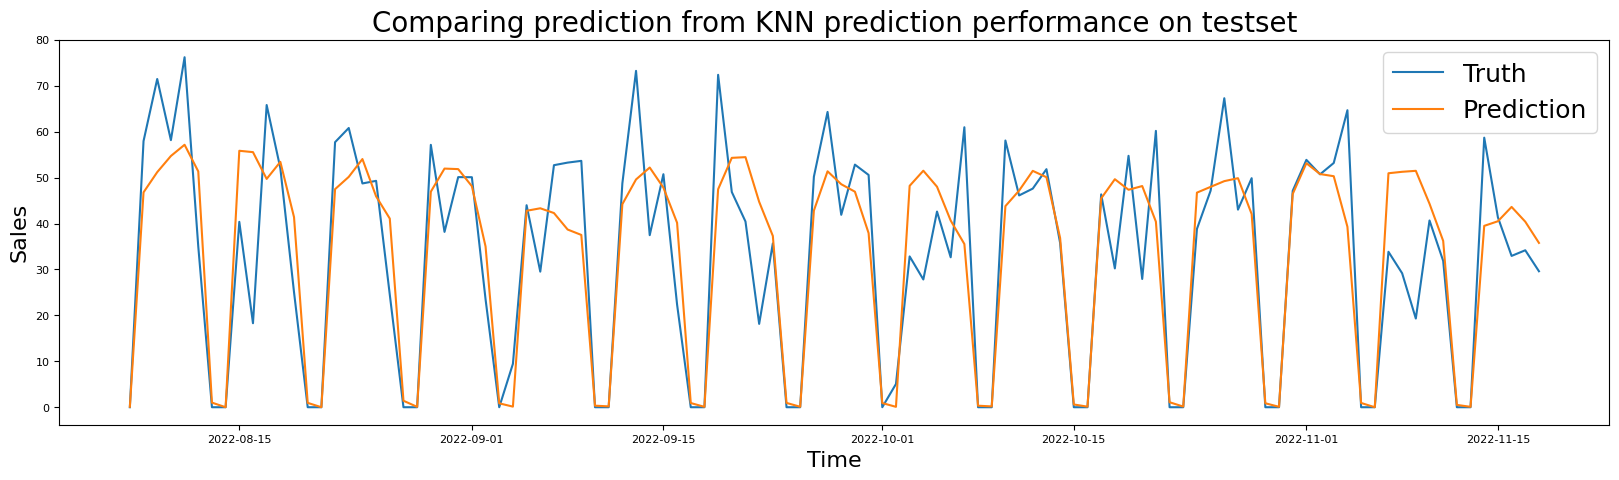

In [24]:
plotprediction(ytest_df, knn_preds.flatten(), 
               'KNN prediction performance on testset')

In [25]:
o_trs = {'mse':[],'mae':[], 'r2':[], 'precision 10%':[], 'precision 20%':[],'precision 30%':[],}
index = all_outcome.keys()
i =  0
for mod in index:
    for m in ['mse','mae', 'r2', 'precision 10%', 'precision 20%', 'precision 30%']:
        o_trs[m].append(all_outcome[mod][m])
    
pd.DataFrame(data=o_trs, index=index)

,mse,mae,r2,precision 10%,precision 20%,precision 30%
OLS,140.071161,8.840421,0.744416,0.346154,0.500000,0.615385
lasso,143.034015,8.878780,0.739010,0.326923,0.509615,0.605769
Ridge,139.179293,8.632244,0.746044,0.355769,0.519231,0.615385
KNN15,143.408589,8.369685,0.738327,0.461538,0.615385,0.721154
